In [17]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from numpy import array
import scipy as sp
import scipy.stats as sps
from scipy.stats import norm
import math
import matplotlib as mp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import quad
import os

In [2]:
#data scrapping from yahoo finance

def fetch_yahoo_finance_data(start_date, end_date, max_iterations=10):
    data = []
    iteration = 0

    while iteration < max_iterations:
        start_timestamp = int(pd.Timestamp(start_date).timestamp())
        end_timestamp = int(pd.Timestamp(end_date).timestamp())

        url = f'https://finance.yahoo.com/quote/%5EGSPC/history?period1={start_timestamp}&period2={end_timestamp}&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true'

        user_agent = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'
        }

        SP500data = requests.get(url, headers=user_agent)
        soup = BeautifulSoup(SP500data.content, 'html.parser')

        #Extract data from the table with class 'W(100%) M(0)'
        SP500histdata = soup.find('table', class_='W(100%) M(0)')

        if SP500histdata:
            for row in SP500histdata.find_all('tr', class_="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)")[1:]:
                columns = row.find_all('span')
                if columns:
                    date = columns[0].text.strip()
                    open_price = float(columns[1].text.strip().replace(',', ''))
                    high = float(columns[2].text.strip().replace(',', ''))
                    low = float(columns[3].text.strip().replace(',', ''))
                    close = float(columns[4].text.strip().replace(',', ''))
                    data.append((date, open_price, high, low, close))

            #Create a DataFrame from the extracted data
            df = pd.DataFrame(data, columns=['Date', 'Open', 'High', 'Low', 'Close'])

            #If the DataFrame is not empty, update the end_date for the next iteration
            if not df.empty:
                end_date = df['Date'].iloc[-1]
                print(f"Retrieved data until {end_date}") # allows to track the realisation of the code
                iteration += 1
            else:
                break
        else:
            break



    return pd.DataFrame(data, columns=['Date', 'Open', 'High', 'Low', 'Close'])

In [3]:
#Define start and end dates
start_date = '1990-01-01'
end_date = '2019-04-01'

#Fetch historical data
sp500_df = fetch_yahoo_finance_data(start_date, end_date, max_iterations=74) #change the number of iteration if necessary

Retrieved data until Nov 02, 2018
Retrieved data until Jun 13, 2018
Retrieved data until Jan 19, 2018
Retrieved data until Aug 25, 2017
Retrieved data until Apr 04, 2017
Retrieved data until Nov 08, 2016
Retrieved data until Jun 17, 2016
Retrieved data until Jan 26, 2016
Retrieved data until Sep 01, 2015
Retrieved data until Apr 10, 2015
Retrieved data until Nov 13, 2014
Retrieved data until Jun 24, 2014
Retrieved data until Jan 30, 2014
Retrieved data until Sep 06, 2013
Retrieved data until Apr 16, 2013
Retrieved data until Nov 19, 2012
Retrieved data until Jun 26, 2012
Retrieved data until Feb 02, 2012
Retrieved data until Sep 09, 2011
Retrieved data until Apr 18, 2011
Retrieved data until Nov 23, 2010
Retrieved data until Jul 02, 2010
Retrieved data until Feb 09, 2010
Retrieved data until Sep 16, 2009
Retrieved data until Apr 24, 2009
Retrieved data until Nov 28, 2008
Retrieved data until Jul 09, 2008
Retrieved data until Feb 14, 2008
Retrieved data until Sep 21, 2007
Retrieved data

In [4]:
sp500_df.head()

,Date,Open,High,Low,Close
0,"Mar 28, 2019",2809.40,2819.71,2798.77,2815.44
1,"Mar 27, 2019",2819.72,2825.56,2787.72,2805.37
2,"Mar 26, 2019",2812.66,2829.87,2803.99,2818.46
3,"Mar 25, 2019",2796.01,2809.79,2785.02,2798.36
4,"Mar 22, 2019",2844.52,2846.16,2800.47,2800.71


Text(0, 0.5, 'Close Price')

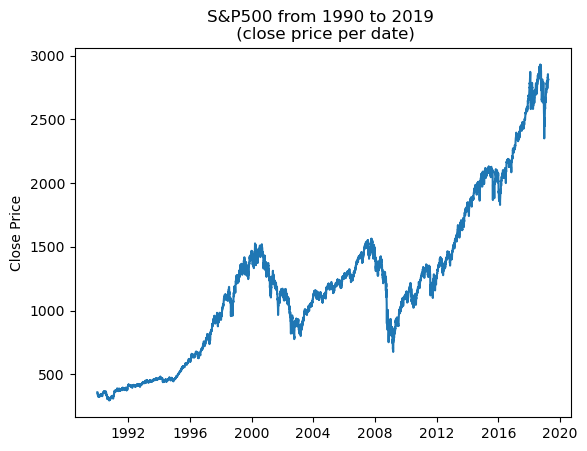

In [5]:
#Convert the 'Date' column to datetime and format it
sp500_df.sort_index(ascending=False, inplace=True)
sp500_df['Date']= pd.to_datetime(sp500_df['Date'], format='%b %d, %Y')
sp500_df['Date'] = sp500_df['Date'].dt.date


#Plot close price vs date with year labels
fig, ax = plt.subplots()

ax.plot(sp500_df['Date'], sp500_df['Close'])
ax.set_title('S&P500 from 1990 to 2019 \n (close price per date)')
ax.set_ylabel('Close Price')

In [9]:
#Calculate daily log returns
CtCLogReturn_df = pd.DataFrame(columns=['Date','Log_Return'])
CtCLogReturn_df['Date']=sp500_df['Date']
CtCLogReturn_df['Log_Return'] = np.log(sp500_df['Close'] / sp500_df['Close'].shift(1))

#Arranging Date in CtCLogReturn
CtCLogReturn_df = CtCLogReturn_df.sort_values(by='Date')  #Ensure the DataFrame is sorted by date

#Drop the first row since it doesn't have a previous day's close
CtCLogReturn_df = CtCLogReturn_df.dropna()

###### Testing serial correlation of returns using the Ljung-Box test 

In [8]:
#Check missing values and convert 'Log_Return' to numeric if needed
CtCLogReturn_df = CtCLogReturn_df.dropna(subset=['Log_Return'])
CtCLogReturn_df['Log_Return'] = pd.to_numeric(CtCLogReturn_df['Log_Return'], errors='coerce')

#Serial Correlation Test (Ljung-Box Test with 8 lags)

lb_test_stat = pd.DataFrame(acorr_ljungbox(CtCLogReturn_df['Log_Return'], lags=8))

#Display results 
print(f"\nLjung-Box Test Statistic:\n\n{lb_test_stat}")


Ljung-Box Test Statistic:

     lb_stat     lb_pvalue
1  22.916871  1.691606e-06
2  34.048652  4.040444e-08
3  34.048653  1.934882e-07
4  34.658217  5.460158e-07
5  38.694265  2.736232e-07
6  39.390001  6.001829e-07
7  49.975038  1.460876e-08
8  54.550668  5.397712e-09


###### Testing that Log-returns are normally distributed using the Jarque-Bera test

In [10]:
jb_test_stat = sp.stats.jarque_bera(CtCLogReturn_df['Log_Return'])
print(f"\nJarque-Bera Test Statistic:\n\n{jb_test_stat}")


Jarque-Bera Test Statistic:

SignificanceResult(statistic=23481.02511507166, pvalue=0.0)


In [13]:
CtCLogReturn_df['Log_Return'].skew()

-0.2726792678241634

In [14]:
CtCLogReturn_df['Log_Return'].kurt()

8.780363462455234

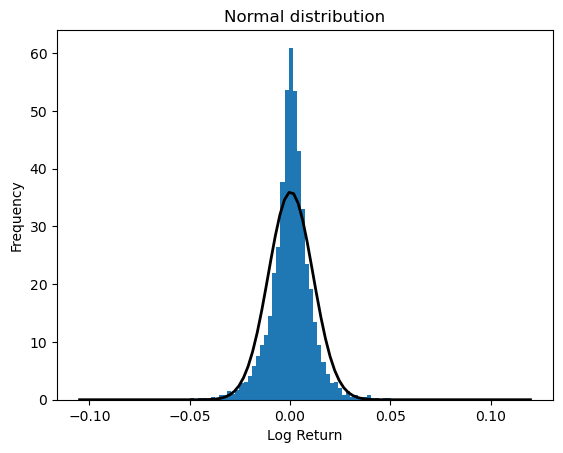

In [18]:
#Display normal distribution to check the distribution of our data
mu, std = norm.fit(CtCLogReturn_df['Log_Return']) 

plt.hist(CtCLogReturn_df['Log_Return'], bins=100, density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
 
plt.plot(x, p, 'k', linewidth=2)

plt.ylabel('Frequency')
plt.xlabel('Log Return') 
plt.title("Normal distribution")
plt.show()

###### Yang & Zhang Estimator of Volatility

In [62]:
Date=sp500_df["Date"]
years=np.array([str(Date[i])[0:4] for i in range(0,len(Date))])

sp500_jan90=sp500_df.iloc[years=='1990',:].copy()

sp500_df['Date']= pd.to_datetime(sp500_df['Date'])

sp500_jan90 = sp500_df[(sp500_df['Date'].dt.year == 1990) & (sp500_df['Date'].dt.month == 1)]
sp500_jan90['Date']=sp500_jan90['Date'].dt.date

len(sp500_jan90)

/var/folders/_5/1cyvh6h96znfqjfg9t3f55nh0000gp/T/ipykernel_73544/3484911465.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_jan90['Date']=sp500_jan90['Date'].dt.date


22

In [80]:
def YZVol(price_data, clean=True):

    window = 22
    
    log_HO = np.log(price_data['High'] / price_data['Open'])
    log_LO = np.log(price_data['Low'] / price_data['Open'])
    log_CO = np.log(price_data['Close'] / price_data['Open'])

    log_OC = (price_data["Open"] / price_data["Close"].shift(1)).apply(np.log)
    log_CC = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    log_OC_sq = log_OC ** 2
    log_CC_sq = log_CC ** 2


    var_oc = np.std(log_OC)**2
    var_co = np.std(log_CO)**2

    var_rs = log_HO * (log_HO - log_CO) + log_LO * (log_LO - log_CO)
    
    #close_vol = log_CC_sq.rolling(window=window, center=False).sum() * (1.0 / (window - 1.0)) #see lecture 1 for the correction equation
    #open_vol = log_OC_sq.rolling(window=window, center=False).sum() * (1.0 / (window - 1.0))
    #window_rs = var_rs.rolling(window=window, center=False).sum() * (1.0 / (window - 1.0))

    k = 0.34 / (1.34 + (window + 1) / (window - 1))

    result = (var_oc + k * var_co + (1 - k) * var_rs)

    if clean:
        return result.dropna()
    else:
        return result

<Axes: title={'center': 'Yang and Zhang Volatility'}, xlabel='Date', ylabel='Volatility (in %)'>

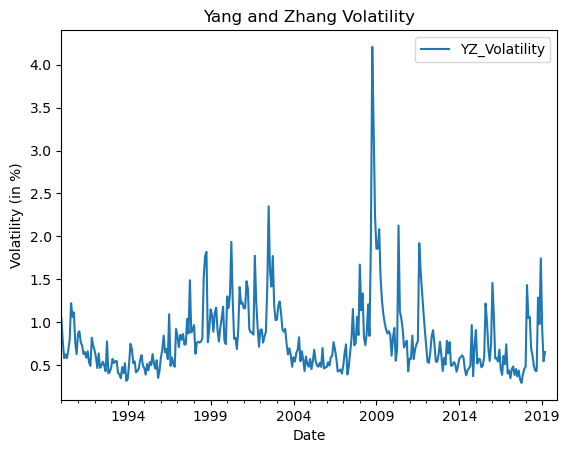

In [83]:
data = []
yearYZVOL = []
for i in range(1990,2020):
    for j in range(1,13):
        sp500_permonth = sp500_df[(sp500_df['Date'].dt.year == i) & (sp500_df['Date'].dt.month == j)].copy()
        sp500_permonth['Date']=sp500_permonth['Date'].dt.date

        data.append((i,j,YZVol(sp500_permonth).mean()**0.5*100))

YZvol_df = pd.DataFrame(data, columns=['Year','Month','YZ_Volatility'])
YZvol_df['Date'] = pd.to_datetime(YZvol_df[['Year', 'Month']].assign(DAY=1))

YZvol_df.plot(x='Date', y='YZ_Volatility', title='Yang and Zhang Volatility', ylabel='Volatility (in %)')